<a href="https://colab.research.google.com/github/souhaklibi/park-foundation/blob/main/sparks_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##New SectionGRIP : The Sparks Foundation Data Science & Business Analytics     GRIP @ The Sparks Foundation
    
# Task 7 : Stock Market Prediction using Numerical and Textual Analysis
Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines
Level : Advanced

Author Name : Klibi Souha

Batch : November 2022

Programming Language : python

Dataset download link : Download historical stock prices from finance.yahoo.com  

In [ ]:
!sudo apt-get update -y

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 172 kB in 1s (130 kB/s)
Reading package lists... Done

In [ ]:
! pip install plotly==5.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

# *cleaning News Data set*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columns=['Date','Category','News']
news=pd.read_csv('/content/drive/MyDrive/sparks/india-news-headlines.csv', delimiter=",",names=columns)
news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650971 entries, 0 to 3650970
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Date      object
 1   Category  object
 2   News      object
dtypes: object(3)
memory usage: 83.6+ MB


In [ ]:
news.isnull()
news.isna()

,Date,Category,News
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
3650966,False,False,False
3650967,False,False,False
3650968,False,False,False
3650969,False,False,False


In [ ]:
news.drop(0, inplace=True)
news.drop('Category', axis = 1, inplace=True)
news['Date'] = pd.to_datetime(news['Date'], format='%Y%m%d').astype('datetime64[ns]')

In [ ]:
# grouping the news headlines according to 'Date'
news= news.groupby(['Date'])['News'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
news.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
news= news.sort_index(ascending=True, axis=0)
news

,News
Date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


# *stocks data_set*

In [ ]:
df_prices = pd.read_csv('https://raw.githubusercontent.com/Syedmukarram951/Spark--Assignment-7/main/%5EBSESN.csv')
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


In [ ]:
df_prices['Date'] = pd.to_datetime(df_prices['Date']).astype('datetime64[ns]')

In [ ]:
df_prices.dropna(inplace=True)
df_prices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37804.237375,38071.182859,37422.826992,37745.454117,37745.454117,19134.000000
std,4507.985769,4380.974060,4647.212947,4535.304336,4535.304336,16540.261333
min,26499.810547,27462.869141,25638.900391,25981.240234,25981.240234,0.000000
25%,34369.659179,34779.932618,33975.389648,34257.097656,34257.097656,13125.000000
50%,38489.480469,38750.359375,38234.869140,38425.974610,38425.974610,17000.000000
75%,41179.222656,41376.482422,41023.923828,41135.233399,41135.233399,21075.000000
max,46774.320313,46992.570313,46627.601563,46890.339844,46890.339844,188300.000000


## *Stock Data Analysis*

In [ ]:
df_prices['year'] = pd.DatetimeIndex(df_prices['Date']).year
df_prices['Month']=(df_prices['Date']).dt.strftime('%m').astype(int)

In [ ]:
fig = px.box(df_prices, x='Month', y="Close")
fig.show()

as we can see we have some aberrant variables , they can probably slightly affect the model 

In [ ]:
#getting rid of the aberrant variables
for x in ['Close']:
    q75,q25 = np.percentile(df_prices.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df_prices.loc[df_prices[x] < min,x] = np.nan
    df_prices.loc[df_prices[x] > max,x] = np.nan

df_prices = df_prices.dropna(axis = 0)
df_prices.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
year         0
Month        0
dtype: int64

In [ ]:
df_prices.sort_values(by=['Date'], ascending = False).tail()
df_prices.set_index('Date', inplace= True)

## *stocks visualization*

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=df_prices.index,
                open=df_prices['Open'],
                high=df_prices['High'],
                low=df_prices['Low'],
                close=df_prices['Close'])])

fig.show()

## *standard deviation*

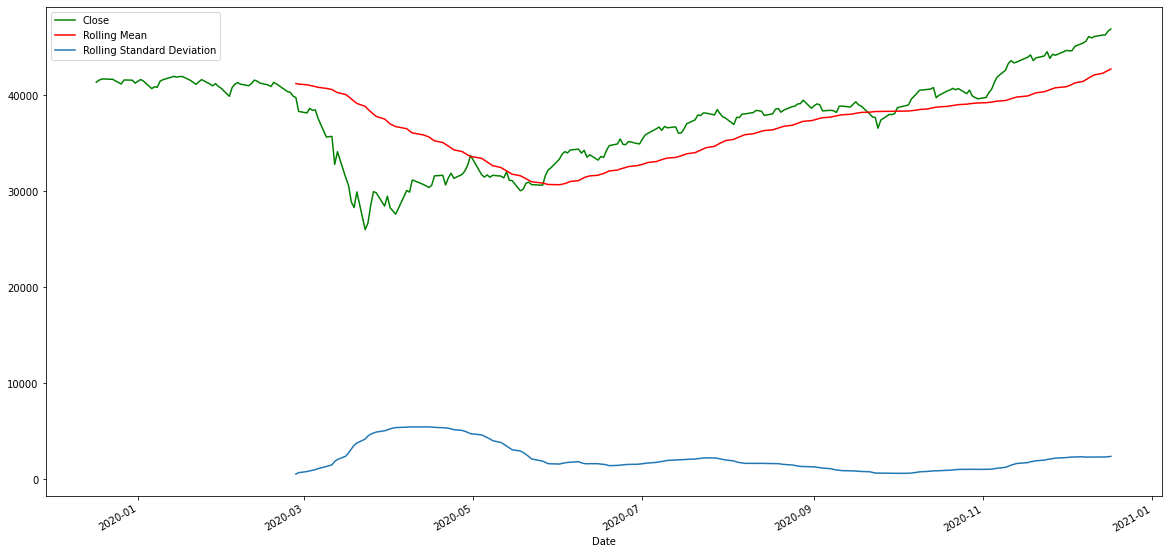

In [ ]:
close =df_prices['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
df_prices['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

# *isolating the time series from the Trend and Seasonality*

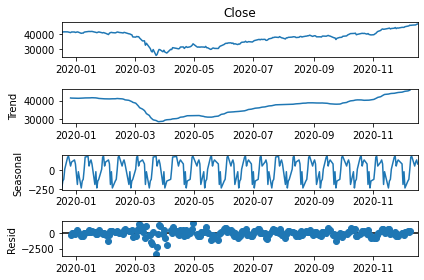

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(df_prices['Close'],model='additive', period=12)

# Plot decomposition
decomp.plot();
plt.tight_layout();

as the chart illustrates we have a seasonality in the presence of a trend , with a frequence of 25 days


## *cheking from the stationarity with ADF_test*

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
adf_test(df_prices['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.698285
p-value                          0.847193
#Lags Used                       6.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


# *differentiating*

In [ ]:
#using diff() methode to defrentiate with a sated frequency of a day-1 using shift ()
diff=df_prices.diff().shift(1)
diff= pd.DataFrame(diff)
diff.dropna(inplace=True)
diff

,Open,High,Low,Close,Adj Close,Volume,year,Month
Date,,,,,,,,
2019-12-19,390.390625,213.121093,353.289062,206.398438,206.398438,5300.0,0.0,0.0
2019-12-20,129.070313,104.519532,97.929688,115.351562,115.351562,9000.0,0.0,0.0
2019-12-23,174.378906,90.671875,179.710937,7.617188,7.617188,300.0,0.0,0.0
2019-12-24,-197.937500,-108.339844,-161.500000,-38.878907,-38.878907,-27400.0,0.0,0.0
2019-12-26,136.250000,1.359375,-51.539062,-181.398437,-181.398437,-1800.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2020-12-11,108.382812,-120.132813,-106.140625,-143.621094,-143.621094,-8000.0,0.0,0.0
2020-12-14,60.898438,265.660156,20.347656,139.132813,139.132813,13600.0,0.0,0.0
2020-12-15,224.378906,63.710938,245.312500,154.449219,154.449219,-7900.0,0.0,0.0


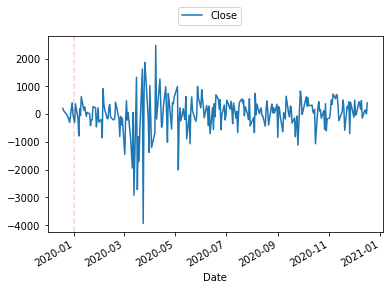

In [ ]:
x=diff['Close']
ax = x.plot()
ax.legend(ncol=5, 
          loc='upper center',
          bbox_to_anchor=(0.5, 1.0),
          bbox_transform=plt.gcf().transFigure)
for yr in range(2020, 2021):
    ax.axvline(pd.to_datetime(str(yr)+"-01-01"), color ="red", linestyle = "--", alpha = 0.2)

##  Partial Auto-Correlation Function (PACF) plot


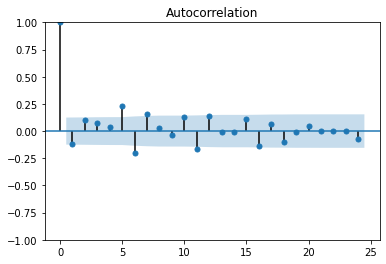

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(x)
plt.show()

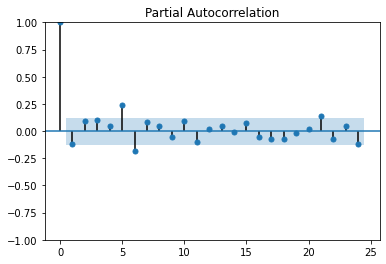

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(x)
plt.show()

In [ ]:
def adf_test(series):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
adf_test(x)



Results of Dickey-Fuller Test:
Test Statistic                  -5.459151
p-value                          0.000003
#Lags Used                       5.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


p_value is way smaller than 0.05 so the serie is stationary

# prediction with Arima model

In [ ]:
!pip install statsmodels
!pip install  pmdarima


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
from datetime import timedelta
from time import time

In [ ]:
fit = auto_arima(diff['Close'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4109.575, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4002.091, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4107.577, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3964.495, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3951.645, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3921.084, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3921.834, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3919.084, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3949.645, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3919.829, Time=0

In [ ]:
train = df_prices[:125]
test = df_prices[125:]
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

In [ ]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-537.046, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-540.075, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-541.630, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-541.308, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-541.757, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-539.665, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.131 seconds


Text(0, 0.5, 'Actual Stock Price')

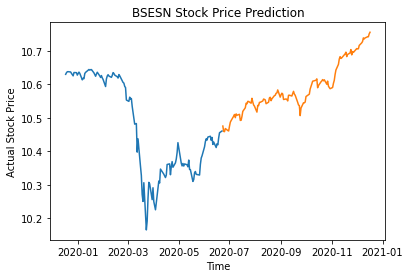

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

# *Sentiment Analysis*

In [ ]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([df_prices,news], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Open,High,Low,Close,Adj Close,Volume,year,Month,News
Date,,,,,,,,,
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,2019.0,12.0,After Jagannath Temple; Puri beach devpt plan ...
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,2019.0,12.0,What is Citizenship (Amendment) Bill 2019: All...
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,2019.0,12.0,Only 61% of CCA covered after revamp of canals...
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,2019.0,12.0,I'm done playing the good girl; I want to be a...
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,2019.0,12.0,Weekly Horoscope; December 22-28: Check predic...
...,...,...,...,...,...,...,...,...,...
2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0,2020.0,12.0,Ways to get you in the mood for sex when you'r...
2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0,2020.0,12.0,"No threat from Covid claims to balance sheets,..."
2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0,2020.0,12.0,1;147 RT-PCR tests in a day; only 3 found +ve ...


In [ ]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,year,Month,News,compound,negative,neutral,positive
Date,,,,,,,,,,,,,
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,2019.0,12.0,After Jagannath Temple; Puri beach devpt plan ...,,,,
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,2019.0,12.0,What is Citizenship (Amendment) Bill 2019: All...,,,,
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,2019.0,12.0,Only 61% of CCA covered after revamp of canals...,,,,
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,2019.0,12.0,I'm done playing the good girl; I want to be a...,,,,
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,2019.0,12.0,Weekly Horoscope; December 22-28: Check predic...,,,,


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['News'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['News'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['News'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['News'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,year,Month,News,compound,negative,neutral,positive
Date,,,,,,,,,,,,,
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,2019.0,12.0,After Jagannath Temple; Puri beach devpt plan ...,-1.0000,0.178,0.748,0.074
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,2019.0,12.0,What is Citizenship (Amendment) Bill 2019: All...,-0.9999,0.146,0.782,0.072
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,2019.0,12.0,Only 61% of CCA covered after revamp of canals...,-0.9997,0.110,0.833,0.057
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,2019.0,12.0,I'm done playing the good girl; I want to be a...,-0.9999,0.156,0.770,0.074
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,2019.0,12.0,Weekly Horoscope; December 22-28: Check predic...,-0.9997,0.132,0.786,0.083


## *Data Preparation*

In [ ]:
stock_data1 = stock_data.copy()
stock_data1.reset_index(drop=True, inplace=True)
stock_data1.drop(['News','year','Month'],axis=1,inplace=True)

In [ ]:
stock_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    float64
 6   compound   250 non-null    float64
 7   negative   250 non-null    float64
 8   neutral    250 non-null    float64
 9   positive   250 non-null    float64
dtypes: float64(10)
memory usage: 19.7 KB


In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(stock_data1))
df.columns = stock_data1.columns
df.index = stock_data1.index
df.head()

,Open,High,Low,Close,Adj Close,Volume,compound,negative,neutral,positive
0,0.717776,0.713722,0.732121,0.735131,0.735131,0.100903,0.00000,0.830645,0.143885,0.345679
1,0.737031,0.724635,0.748954,0.745002,0.745002,0.129049,0.00005,0.572581,0.388489,0.320988
2,0.743397,0.729987,0.753620,0.750519,0.750519,0.176845,0.00015,0.282258,0.755396,0.135802
3,0.751998,0.734629,0.762182,0.750884,0.750884,0.178439,0.00005,0.653226,0.302158,0.345679
4,0.742235,0.729082,0.754487,0.749024,0.749024,0.032926,0.00015,0.459677,0.417266,0.456790


In [ ]:
X=df.drop('Close',axis=1)
Y=df['Close']

##*Split the Dataset into Train & Test Data*

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(200, 9)

# *Random forest Regressor*

In [ ]:
model0= RandomForestRegressor()
model0.fit(x_train, y_train)
prediction=model0.predict(x_test)
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))
print('training :',model0.score(x_train , y_train))
print('testing :',model0.score(x_test , y_test))

[0.83456258 0.38372017 0.26881975 0.57704712 0.54062421 0.59139704
 0.62320056 0.24870158 0.09565726 0.54987749]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
Mean Squared error:  8.416956145757821e-05
training : 0.9996292757714513
testing : 0.9978184024746233


# *Decision Tree Regressor*

In [ ]:
model1 = DecisionTreeRegressor()
model1.fit(x_train, y_train)
predictions = model1.predict(x_test)
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))
print('training :',model1.score(x_train , y_train))
print('testing :',model1.score(x_test , y_test))

[0.83512729 0.38143446 0.26897287 0.57723868 0.52794719 0.59189251
 0.62167246 0.24470161 0.13813457 0.54702251]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
Mean Squared error:  0.00023029681848724462
training : 1.0
testing : 0.9940309185338085


## *Ada Boost Regressor*

In [ ]:
model2 = AdaBoostRegressor()
model2.fit(x_train, y_train)
predictions =model2.predict(x_test)
print(mean_squared_error(predictions, y_test))
print('training :',model2.score(x_train , y_train))
print('testing :',model2.score(x_test , y_test))

0.0001962021834157658
training : 0.9970954177348449
testing : 0.9949146200787911


as we can see all the three models almost performed a perfect score hiwever the RandomForestRegressor shows a better performance than the others with a Mean Squared error:  8.416956145757821e-05 and an accuracy of :

(training : 0.9996292757714513, and  testing : 0.9978184024746233)